In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')




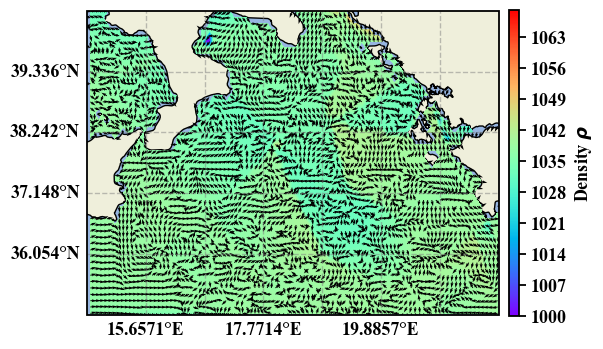

In [129]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from global_land_mask import globe
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def draw_rho_cur(LON, LAT, rho0, u0, v0):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([14.6, 22, 34.96, 40.43], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    
    # Add gridlines beneath the data, add labels, and set line style and other formatting
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right
    
    # Customize the tick labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # Set the number of grid lines (and thus tick labels) you want to display
    gl.xlocator = matplotlib.ticker.FixedLocator(np.linspace(14.6, 22, num=8))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.linspace(34.96, 40.43, num=6))
    
    for i, (lon, lat) in enumerate(zip(LON.values.flatten(), LAT.values.flatten())):
        if globe.is_land(lat, lon):
            u0.iloc[i // LON.shape[1], i % LON.shape[1]] = None
            v0.iloc[i // LON.shape[1], i % LON.shape[1]] = None
            rho0.iloc[i // LON.shape[1], i % LON.shape[1]] = None
    
    
    # 绘制箭头图
    rho0[rho0<1000] = 1000
    rho0[rho0>1070] = 1070
    
    cmap = plt.get_cmap('rainbow')
    levels = np.arange(rho0.min().min(), rho0.max().max(), 0.1)  # Set the range of values for the heatmap
    
    heatmap = ax.contourf(LON, LAT, rho0, levels=levels, cmap=cmap, transform=ccrs.PlateCarree())

    # Add a colorbar
    cbar = plt.colorbar(heatmap, orientation='vertical', pad=0.02, aspect=30, shrink=0.83)
    cbar.set_label('Density ' + r'$\rho$')
    
    u0_magnitude = np.sqrt(u0**2 + v0**2)
    u0_normalized = u0 / (u0_magnitude + 1e-6)
    v0_normalized = v0 / (u0_magnitude + 1e-6)
    ax.quiver(LON, LAT, u0_normalized, v0_normalized,scale=65,transform=ccrs.PlateCarree())
    # ax.quiver(LON, LAT, u0, v0, scale=5, transform=ccrs.PlateCarree())
    plt.savefig('fig/密度洋流0m.png', bbox_inches='tight', transparent=True, dpi=380)

LON = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='LON',header=None)
LAT = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='LAT',header=None)
rho0 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='rho0',header=None)
u0 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='u0',header=None)
v0 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='v0',header=None)
rho999 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='rho-999',header=None)
u999 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='u-999',header=None)
v999 = pd.read_excel('data2py/cur_rho.xlsx',sheet_name='v-999',header=None)

draw_rho_cur(LON, LAT, rho0, u0, v0)


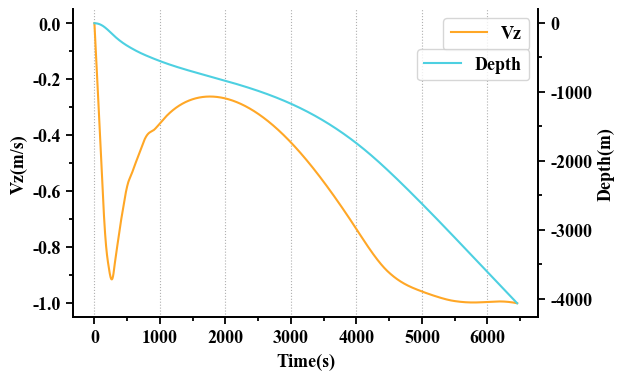

In [168]:
# 注水后下降的速度
plt.rcParams['axes.spines.right'] = True
t_mw = pd.read_excel('data2py/mw.xlsx',sheet_name='t',header=None)
xyz_t_mw = pd.read_excel('data2py/mw.xlsx',sheet_name='xyz_v',header=None)


fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t_mw, xyz_t_mw.iloc[:, 5],color='#FFA726')
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel('Time(s)')
ax.set_ylabel('Vz(m/s)')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.grid(False)
ax.legend(['Vz'])
# 
ax2 = ax.twinx()
ax2.plot(t_mw, xyz_t_mw.iloc[:, 2],color='#4DD0E1')
ax2.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax2.set_ylabel('Depth(m)')
ax2.yaxis.grid(False)
ax2.legend(['Depth'], bbox_to_anchor=(1, 0.9))

# 名字，去白边，背景透明
plt.savefig('fig/注水下潜.pdf', bbox_inches='tight', transparent=False)

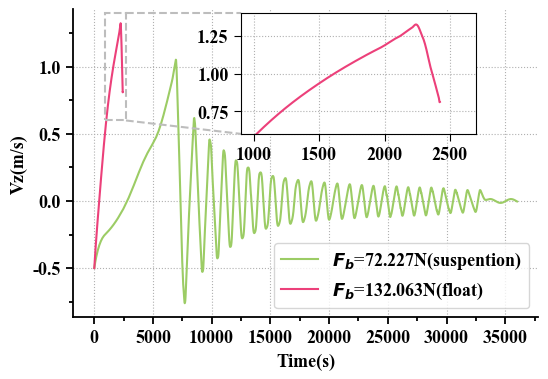

In [29]:
def my_zoom(x, y, ax, axin_size, xlim, ylim, loc):
    # 创建缩放图
    axins = ax.inset_axes(axin_size, transform=ax.transData)
    axins.plot(x, y,color='#EC407A')
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    for key in axins.spines:
        axins.spines[key].set_visible(True)
        axins.spines[key].set_linewidth(0.8)
    axins.tick_params(axis='both', which='both', width=0.8)
    rectpatch, connects=ax.indicate_inset_zoom(axins, linestyle='--', linewidth=1.5, edgecolor='#BDBDBD', alpha=1)
    # 移除所有原来的连线
    for con in connects:
        con.set_visible(False)
    
    # 构建所有框选区域
    ax_pos = [(xlim[0], ylim[1]),(xlim[1], ylim[1]),
              (xlim[0], ylim[0]),(xlim[1], ylim[0])]
    axin_pos = [(axin_size[0], axin_size[1] + axin_size[3]),
                (axin_size[0] + axin_size[2], axin_size[1] + axin_size[3]),
                (axin_size[0], axin_size[1]),
                (axin_size[0] + axin_size[2], axin_size[1])]
    for i in range(4):
        if loc[i] == 0:
            continue
        else:
            ax.plot([ax_pos[i][0], axin_pos[loc[i]-1][0]], 
                    [ax_pos[i][1], axin_pos[loc[i]-1][1]], 
                    linewidth=1.5, linestyle='--', color='#BDBDBD')
            
t0_Fb = pd.read_excel('data2py/Fb.xlsx',sheet_name='t0',header=None)
t1_Fb = pd.read_excel('data2py/Fb.xlsx',sheet_name='t1',header=None)
xyz0_Fb = pd.read_excel('data2py/Fb.xlsx',sheet_name='xyz_v0',header=None)
xyz1_Fb = pd.read_excel('data2py/Fb.xlsx',sheet_name='xyz_v1',header=None)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t0_Fb, xyz0_Fb.iloc[:,5],color='#9CCC65')
ax.plot(t1_Fb, xyz1_Fb.iloc[:,5],color='#EC407A')
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel('Time(s)')
ax.set_ylabel('Vz(m/s)')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.legend(['$F_b$=72.227N(suspention)','$F_b$=132.063N(float)'],loc=4)
# 缩放图的位置[左下角x, 左下角y, xlen, ylen]
axin_size = [12500, 0.5, 20000, 0.9]
# 缩放内容区间
xlim = [900, 2700]
ylim = [0.6, 1.4]
loc = [0, 1, 0, 3]
# loc[0]=0：不连接
# loc[0]=3：原图框选区域的左上角坐标与axins的左下角连接
# loc[3]=1：原图框选区域的右下角坐标与axins的左上角连接
# 左上，右上，左下，右下

# 调用函数绘制连线
my_zoom(t1_Fb, xyz1_Fb.iloc[:,5], ax, axin_size, xlim, ylim, loc)

# 名字，去白边，背景透明
plt.savefig('fig/悬浮漂浮.pdf', bbox_inches='tight', transparent=False)

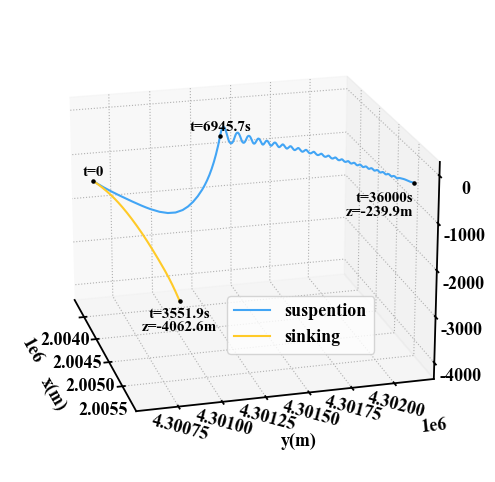

In [127]:
# 沉底三维图

%matplotlib inline
# matplotlib.use('TkAgg')

t_sus = pd.read_excel('data2py/suspension.xlsx',sheet_name='t',header=None)
xyz_sus = pd.read_excel('data2py/suspension.xlsx',sheet_name='xyz_v',header=None)
t_sink = pd.read_excel('data2py/sink.xlsx',sheet_name='t',header=None)
xyz_sink = pd.read_excel('data2py/sink.xlsx',sheet_name='xyz_v',header=None)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.plot(xyz_sus.iloc[:,0], xyz_sus.iloc[:,1], xyz_sus.iloc[:,2], color='#42A5F5')
ax.plot(xyz_sink.iloc[:,0], xyz_sink.iloc[:,1], xyz_sink.iloc[:,2], color='#FFCA28')
ax.set_xlabel('x(m)', labelpad=10, rotation=-60)
ax.set_ylabel('y(m)', labelpad=3)
ax.yaxis.set_tick_params(labelrotation=-15, pad=-5)
ax.legend(['suspention','sinking'],bbox_to_anchor=(0.45, 0.4))
ax.view_init(elev=20, azim=-15)

# 插入文字
ax.text(xyz_sus.iloc[0,0], xyz_sus.iloc[0,1], xyz_sus.iloc[0,2]+100, "t=0", fontsize=11, ha='center')
ax.scatter(xyz_sus.iloc[0,0], xyz_sus.iloc[0,1], xyz_sus.iloc[0,2], s=5, c='black')
ax.text(xyz_sus.iloc[42,0], xyz_sus.iloc[42,1], xyz_sus.iloc[42,2]+100, "t=6945.7s", fontsize=11, ha='center')
ax.scatter(xyz_sus.iloc[42,0], xyz_sus.iloc[42,1], xyz_sus.iloc[42,2], s=5, c='black')
ax.text(xyz_sus.iloc[-1,0], xyz_sus.iloc[-1,1], xyz_sus.iloc[-1,2]-400, "t=36000s", fontsize=11, ha='right')
ax.text(xyz_sus.iloc[-1,0], xyz_sus.iloc[-1,1], xyz_sus.iloc[-1,2]-700, "z=-239.9m", fontsize=11, ha='right')
ax.scatter(xyz_sus.iloc[-1,0], xyz_sus.iloc[-1,1], xyz_sus.iloc[-1,2], s=5, c='black')
ax.text(xyz_sink.iloc[-1,0], xyz_sink.iloc[-1,1], xyz_sink.iloc[-1,2]-400, "t=3551.9s", fontsize=11, ha='center')
ax.text(xyz_sink.iloc[-1,0], xyz_sink.iloc[-1,1], xyz_sink.iloc[-1,2]-700, "z=-4062.6m", fontsize=11, ha='center')
ax.scatter(xyz_sink.iloc[-1,0], xyz_sink.iloc[-1,1], xyz_sink.iloc[-1,2], s=5, c='black')
# ax.text(xyz_sus.iloc[0,0], xyz_sus.iloc[0,1], xyz_sus.iloc[0,2]+100, "t=0", fontsize=12, ha='center')
# ax.scatter(xyz_sus.iloc[0,0], xyz_sus.iloc[0,1], xyz_sus.iloc[0,2], s=5, c='black')
# 名字，去白边，背景透明
plt.savefig('fig/沉底悬浮三维图.pdf', bbox_inches='tight', transparent=False)

In [7]:

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

# %matplotlib inline
matplotlib.use('TkAgg')

t = pd.read_excel('data/q1sensitive漂浮.xlsx',sheet_name='xyz_origin').values
X = pd.read_excel('data/q1sensitive漂浮.xlsx',sheet_name='x_rand').values
Y = pd.read_excel('data/q1sensitive漂浮.xlsx',sheet_name='y_rand').values
Z = pd.read_excel('data/q1sensitive漂浮.xlsx',sheet_name='z_rand').values

# 创建三维轴对象
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



# 绘制主轨迹，使用黑色
ax.plot(t[:, 0], t[:, 1], t[:, 2], color='k', label='Main Trajectory')



# 绘制其他的轨迹，使用透明度降低的蓝色，你也可以选择自己喜欢的颜色或风格
for i in range(m):
    ax.plot(X[:, i], Y[:, i], Z[:, i], color='b', alpha=0.1)

# 可选操作: 添加图例，设置坐标轴标签，以及其他美化措施
ax.legend()
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Trajectories')

# 展示图像
plt.pause(100000)

